In [1]:
# ===============================================================
# 🌟 Colab GPU Optimized Resume Ranking & Analysis using BERT
# ===============================================================

# ✅ Install Transformers if not already installed
!pip install transformers --quiet

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 566.1/566.1 kB 11.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 4.1.1 requires pyarrow>=21.0.0, but you have pyarrow 19.0.1 which is incompatible.
gradio 5.38.1 requires pydantic<2.12,>=2.0, but you have pydantic 2.12.0a1 which is incompatible.


2025-10-26 07:00:58.469370: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761462058.631686      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761462058.680750      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# ======================
# GPU Check
# ======================
device = "cuda" if torch.cuda.is_available() else "cpu"
print("✅ Device:", device)

✅ Device: cuda


In [3]:
# ======================
# Load Dataset
# ======================
csv_path = "/kaggle/input/cv-resume-data-set-1k/dataset 1k.csv"  # Upload your dataset to Colab path
df = pd.read_csv(csv_path)

print("Columns in CSV:", df.columns.tolist())
print(df.head())

texts = df["Resume"].astype(str).tolist()
job_roles = df["Role"].astype(str).tolist()
job_desc = df["Job_Description"].astype(str).tolist()
labels_text = df["Decision"].astype(str).tolist()

label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels_text)
print("\nLabel mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))


Columns in CSV: ['Role', 'Resume', 'Decision', 'Reason_for_decision', 'Job_Description']
                         Role  \
0       E-commerce Specialist   
1              Game Developer   
2  Human Resources Specialist   
3       E-commerce Specialist   
4       E-commerce Specialist   

                                              Resume Decision  \
0  Here's a professional resume for Jason Jones:\...   reject   
1  Here's a professional resume for Ann Marshall:...   select   
2  Here's a professional resume for Patrick Mccla...   reject   
3  Here's a professional resume for Patricia Gray...   select   
4  Here's a professional resume for Amanda Gross:...   reject   

                                 Reason_for_decision  \
0    Lacked leadership skills for a senior position.   
1              Strong technical skills in AI and ML.   
2  Insufficient system design expertise for senio...   
3  Impressive leadership and communication abilit...   
4    Lacked leadership skills for a senio

In [4]:
# ======================
# Data Split (Show %)
# ======================
train_ratio, val_ratio, test_ratio = 0.9, 0.10, 0.10
train_texts, temp_texts, train_labels, temp_labels, train_job_roles, temp_job_roles, train_job_desc, temp_job_desc = train_test_split(
    texts, labels, job_roles, job_desc, test_size=(1-train_ratio), random_state=42
)
val_texts, test_texts, val_labels, test_labels, val_job_roles, test_job_roles, val_job_desc, test_job_desc = train_test_split(
    temp_texts, temp_labels, temp_job_roles, temp_job_desc, test_size=test_ratio/(val_ratio+test_ratio), random_state=42
)

print(f"\n📊 Data Split Summary:")
print(f"Train: {len(train_texts)} ({train_ratio*100:.0f}%)")
print(f"Validation: {len(val_texts)} ({val_ratio*100:.0f}%)")
print(f"Test: {len(test_texts)} ({test_ratio*100:.0f}%)")



📊 Data Split Summary:
Train: 900 (90%)
Validation: 50 (10%)
Test: 50 (10%)


In [5]:
# ======================
# Tokenizer
from transformers import BertTokenizer

# Kaggle input folder path ব্যবহার করো
tokenizer_path ="/kaggle/input/ksdfoieeknf/bert_local"
tokenizer = BertTokenizer.from_pretrained(tokenizer_path, use_fast=False)

# Test
text = "This is a test."
encoding = tokenizer(text)
print("✅ Tokenizer loaded successfully!")          

✅ Tokenizer loaded successfully!


In [6]:
# আগে যেটা ছিল
# tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# replace করে local path use করো
tokenizer_path = "/kaggle/input/ksdfoieeknf/bert_local"
tokenizer = BertTokenizer.from_pretrained(tokenizer_path, use_fast=False)

In [7]:
print("✅ Tokenizer loaded successfully!")
print(tokenizer.tokenize("This is a working BERT tokenizer test."))

✅ Tokenizer loaded successfully!
['this', 'is', 'a', 'working', 'bert', 'token', '##izer', 'test', '.']


In [8]:
# ======================
# Dataset Class
# ======================
class ResumeDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt"
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(),
            "attention_mask": encoding["attention_mask"].squeeze(),
            "label": torch.tensor(label, dtype=torch.long)
        }


In [9]:
# ======================
# DataLoader
# ======================
batch_size = 16
train_dataset = ResumeDataset(train_texts, train_labels, tokenizer)
val_dataset = ResumeDataset(val_texts, val_labels, tokenizer)
test_dataset = ResumeDataset(test_texts, test_labels, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [10]:
# ======================
# Model
# ======================
class ResumeClassifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(self.bert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.pooler_output
        cls_output = self.dropout(cls_output)
        return self.fc(cls_output)

model = ResumeClassifier(num_classes=len(set(labels))).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=2e-5)


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [11]:
# ======================
# Training & Evaluation
# ======================
train_losses, val_losses, train_accs, val_accs = [], [], [], []

def evaluate(model, data_loader):
    model.eval()
    correct, total = 0, 0
    all_preds, all_labels, all_probs = [], [], []

    with torch.inference_mode():
        for batch in data_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            outputs = model(input_ids, attention_mask)
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())

    acc = 100 * correct / total
    return acc, all_preds, all_labels, all_probs

def train_model(model, train_loader, val_loader, loss_fn, optimizer, num_epochs=3):
    start_time = time.time()
    for epoch in range(num_epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        avg_train_loss = total_loss / len(train_loader)
        train_acc = 100 * correct / total
        val_acc, _, _, _ = evaluate(model, val_loader)

        train_losses.append(avg_train_loss)
        val_losses.append(1 - val_acc / 100)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        print(f"Epoch {epoch+1}: Train Loss={avg_train_loss:.4f}, Train Acc={train_acc:.2f}%, Val Acc={val_acc:.2f}%")

    end_time = time.time()
    print(f"\nTotal Training Time: {end_time - start_time:.2f} sec")


In [12]:
# Train model
train_model(model, train_loader, val_loader, loss_fn, optimizer, num_epochs=100)


Epoch 1/100: 100%|██████████| 57/57 [00:24<00:00,  2.29it/s]


Epoch 1: Train Loss=0.7121, Train Acc=48.22%, Val Acc=42.00%


Epoch 2/100: 100%|██████████| 57/57 [00:24<00:00,  2.33it/s]


Epoch 2: Train Loss=0.7004, Train Acc=50.67%, Val Acc=42.00%


Epoch 3/100: 100%|██████████| 57/57 [00:24<00:00,  2.30it/s]


Epoch 3: Train Loss=0.6960, Train Acc=52.89%, Val Acc=42.00%


Epoch 4/100: 100%|██████████| 57/57 [00:25<00:00,  2.24it/s]


Epoch 4: Train Loss=0.6924, Train Acc=50.78%, Val Acc=42.00%


Epoch 5/100: 100%|██████████| 57/57 [00:26<00:00,  2.18it/s]


Epoch 5: Train Loss=0.6904, Train Acc=52.56%, Val Acc=42.00%


Epoch 6/100: 100%|██████████| 57/57 [00:26<00:00,  2.15it/s]


Epoch 6: Train Loss=0.6681, Train Acc=58.67%, Val Acc=60.00%


Epoch 7/100: 100%|██████████| 57/57 [00:26<00:00,  2.16it/s]


Epoch 7: Train Loss=0.5326, Train Acc=75.33%, Val Acc=62.00%


Epoch 8/100: 100%|██████████| 57/57 [00:26<00:00,  2.17it/s]


Epoch 8: Train Loss=0.3770, Train Acc=84.78%, Val Acc=64.00%


Epoch 9/100: 100%|██████████| 57/57 [00:26<00:00,  2.18it/s]


Epoch 9: Train Loss=0.1945, Train Acc=92.56%, Val Acc=44.00%


Epoch 10/100: 100%|██████████| 57/57 [00:26<00:00,  2.18it/s]


Epoch 10: Train Loss=0.1409, Train Acc=95.00%, Val Acc=62.00%


Epoch 11/100: 100%|██████████| 57/57 [00:26<00:00,  2.19it/s]


Epoch 11: Train Loss=0.0878, Train Acc=96.89%, Val Acc=62.00%


Epoch 12/100: 100%|██████████| 57/57 [00:26<00:00,  2.17it/s]


Epoch 12: Train Loss=0.0498, Train Acc=98.11%, Val Acc=62.00%


Epoch 13/100: 100%|██████████| 57/57 [00:26<00:00,  2.18it/s]


Epoch 13: Train Loss=0.0496, Train Acc=98.44%, Val Acc=60.00%


Epoch 14/100: 100%|██████████| 57/57 [00:26<00:00,  2.18it/s]


Epoch 14: Train Loss=0.0181, Train Acc=99.33%, Val Acc=56.00%


Epoch 15/100: 100%|██████████| 57/57 [00:26<00:00,  2.18it/s]


Epoch 15: Train Loss=0.0341, Train Acc=98.78%, Val Acc=48.00%


Epoch 16/100: 100%|██████████| 57/57 [00:26<00:00,  2.18it/s]


Epoch 16: Train Loss=0.0742, Train Acc=97.44%, Val Acc=54.00%


Epoch 17/100: 100%|██████████| 57/57 [00:26<00:00,  2.19it/s]


Epoch 17: Train Loss=0.0206, Train Acc=99.44%, Val Acc=62.00%


Epoch 18/100: 100%|██████████| 57/57 [00:26<00:00,  2.18it/s]


Epoch 18: Train Loss=0.0052, Train Acc=99.89%, Val Acc=64.00%


Epoch 19/100: 100%|██████████| 57/57 [00:26<00:00,  2.18it/s]


Epoch 19: Train Loss=0.0017, Train Acc=100.00%, Val Acc=64.00%


Epoch 20/100: 100%|██████████| 57/57 [00:26<00:00,  2.18it/s]


Epoch 20: Train Loss=0.0161, Train Acc=99.67%, Val Acc=68.00%


Epoch 21/100: 100%|██████████| 57/57 [00:26<00:00,  2.19it/s]


Epoch 21: Train Loss=0.0292, Train Acc=99.22%, Val Acc=64.00%


Epoch 22/100: 100%|██████████| 57/57 [00:26<00:00,  2.18it/s]


Epoch 22: Train Loss=0.0086, Train Acc=99.89%, Val Acc=62.00%


Epoch 23/100: 100%|██████████| 57/57 [00:26<00:00,  2.19it/s]


Epoch 23: Train Loss=0.0017, Train Acc=100.00%, Val Acc=62.00%


Epoch 24/100: 100%|██████████| 57/57 [00:26<00:00,  2.19it/s]


Epoch 24: Train Loss=0.0008, Train Acc=100.00%, Val Acc=64.00%


Epoch 25/100: 100%|██████████| 57/57 [00:26<00:00,  2.18it/s]


Epoch 25: Train Loss=0.0008, Train Acc=100.00%, Val Acc=60.00%


Epoch 26/100: 100%|██████████| 57/57 [00:26<00:00,  2.18it/s]


Epoch 26: Train Loss=0.0006, Train Acc=100.00%, Val Acc=62.00%


Epoch 27/100: 100%|██████████| 57/57 [00:26<00:00,  2.18it/s]


Epoch 27: Train Loss=0.0014, Train Acc=100.00%, Val Acc=66.00%


Epoch 28/100: 100%|██████████| 57/57 [00:26<00:00,  2.19it/s]


Epoch 28: Train Loss=0.0006, Train Acc=100.00%, Val Acc=62.00%


Epoch 29/100: 100%|██████████| 57/57 [00:26<00:00,  2.18it/s]


Epoch 29: Train Loss=0.0006, Train Acc=100.00%, Val Acc=62.00%


Epoch 30/100: 100%|██████████| 57/57 [00:26<00:00,  2.19it/s]


Epoch 30: Train Loss=0.0006, Train Acc=100.00%, Val Acc=62.00%


Epoch 31/100: 100%|██████████| 57/57 [00:26<00:00,  2.18it/s]


Epoch 31: Train Loss=0.0291, Train Acc=99.33%, Val Acc=66.00%


Epoch 32/100: 100%|██████████| 57/57 [00:26<00:00,  2.19it/s]


Epoch 32: Train Loss=0.0284, Train Acc=99.44%, Val Acc=64.00%


Epoch 33/100: 100%|██████████| 57/57 [00:26<00:00,  2.19it/s]


Epoch 33: Train Loss=0.0047, Train Acc=99.89%, Val Acc=60.00%


Epoch 34/100: 100%|██████████| 57/57 [00:26<00:00,  2.18it/s]


Epoch 34: Train Loss=0.0569, Train Acc=98.67%, Val Acc=58.00%


Epoch 35/100: 100%|██████████| 57/57 [00:26<00:00,  2.19it/s]


Epoch 35: Train Loss=0.0249, Train Acc=99.33%, Val Acc=56.00%


Epoch 36/100: 100%|██████████| 57/57 [00:26<00:00,  2.18it/s]


Epoch 36: Train Loss=0.0071, Train Acc=99.89%, Val Acc=58.00%


Epoch 37/100: 100%|██████████| 57/57 [00:26<00:00,  2.18it/s]


Epoch 37: Train Loss=0.0024, Train Acc=100.00%, Val Acc=58.00%


Epoch 38/100: 100%|██████████| 57/57 [00:26<00:00,  2.18it/s]


Epoch 38: Train Loss=0.0439, Train Acc=98.78%, Val Acc=60.00%


Epoch 39/100: 100%|██████████| 57/57 [00:26<00:00,  2.18it/s]


Epoch 39: Train Loss=0.0624, Train Acc=97.78%, Val Acc=54.00%


Epoch 40/100: 100%|██████████| 57/57 [00:26<00:00,  2.18it/s]


Epoch 40: Train Loss=0.0206, Train Acc=99.67%, Val Acc=54.00%


Epoch 41/100: 100%|██████████| 57/57 [00:26<00:00,  2.18it/s]


Epoch 41: Train Loss=0.0021, Train Acc=100.00%, Val Acc=58.00%


Epoch 42/100: 100%|██████████| 57/57 [00:26<00:00,  2.18it/s]


Epoch 42: Train Loss=0.0007, Train Acc=100.00%, Val Acc=60.00%


Epoch 43/100: 100%|██████████| 57/57 [00:26<00:00,  2.18it/s]


Epoch 43: Train Loss=0.0005, Train Acc=100.00%, Val Acc=56.00%


Epoch 44/100: 100%|██████████| 57/57 [00:26<00:00,  2.18it/s]


Epoch 44: Train Loss=0.0004, Train Acc=100.00%, Val Acc=60.00%


Epoch 45/100: 100%|██████████| 57/57 [00:26<00:00,  2.18it/s]


Epoch 45: Train Loss=0.0003, Train Acc=100.00%, Val Acc=60.00%


Epoch 46/100: 100%|██████████| 57/57 [00:26<00:00,  2.18it/s]


Epoch 46: Train Loss=0.0003, Train Acc=100.00%, Val Acc=60.00%


Epoch 47/100: 100%|██████████| 57/57 [00:26<00:00,  2.18it/s]


Epoch 47: Train Loss=0.0003, Train Acc=100.00%, Val Acc=60.00%


Epoch 48/100: 100%|██████████| 57/57 [00:26<00:00,  2.18it/s]


Epoch 48: Train Loss=0.0003, Train Acc=100.00%, Val Acc=60.00%


Epoch 49/100: 100%|██████████| 57/57 [00:26<00:00,  2.18it/s]


Epoch 49: Train Loss=0.0002, Train Acc=100.00%, Val Acc=60.00%


Epoch 50/100: 100%|██████████| 57/57 [00:26<00:00,  2.18it/s]


Epoch 50: Train Loss=0.0002, Train Acc=100.00%, Val Acc=60.00%


Epoch 51/100: 100%|██████████| 57/57 [00:26<00:00,  2.19it/s]


Epoch 51: Train Loss=0.0002, Train Acc=100.00%, Val Acc=60.00%


Epoch 52/100: 100%|██████████| 57/57 [00:26<00:00,  2.18it/s]


Epoch 52: Train Loss=0.0001, Train Acc=100.00%, Val Acc=60.00%


Epoch 53/100: 100%|██████████| 57/57 [00:26<00:00,  2.19it/s]


Epoch 53: Train Loss=0.0002, Train Acc=100.00%, Val Acc=62.00%


Epoch 54/100: 100%|██████████| 57/57 [00:26<00:00,  2.19it/s]


Epoch 54: Train Loss=0.0001, Train Acc=100.00%, Val Acc=62.00%


Epoch 55/100: 100%|██████████| 57/57 [00:26<00:00,  2.19it/s]


Epoch 55: Train Loss=0.0001, Train Acc=100.00%, Val Acc=62.00%


Epoch 56/100: 100%|██████████| 57/57 [00:26<00:00,  2.19it/s]


Epoch 56: Train Loss=0.0001, Train Acc=100.00%, Val Acc=62.00%


Epoch 57/100: 100%|██████████| 57/57 [00:26<00:00,  2.18it/s]


Epoch 57: Train Loss=0.0001, Train Acc=100.00%, Val Acc=62.00%


Epoch 58/100: 100%|██████████| 57/57 [00:26<00:00,  2.18it/s]


Epoch 58: Train Loss=0.0001, Train Acc=100.00%, Val Acc=62.00%


Epoch 59/100: 100%|██████████| 57/57 [00:26<00:00,  2.18it/s]


Epoch 59: Train Loss=0.0001, Train Acc=100.00%, Val Acc=60.00%


Epoch 60/100: 100%|██████████| 57/57 [00:26<00:00,  2.17it/s]


Epoch 60: Train Loss=0.0001, Train Acc=100.00%, Val Acc=60.00%


Epoch 61/100: 100%|██████████| 57/57 [00:26<00:00,  2.17it/s]


Epoch 61: Train Loss=0.0001, Train Acc=100.00%, Val Acc=60.00%


Epoch 62/100: 100%|██████████| 57/57 [00:26<00:00,  2.17it/s]


Epoch 62: Train Loss=0.0001, Train Acc=100.00%, Val Acc=60.00%


Epoch 63/100: 100%|██████████| 57/57 [00:26<00:00,  2.18it/s]


Epoch 63: Train Loss=0.0001, Train Acc=100.00%, Val Acc=60.00%


Epoch 64/100: 100%|██████████| 57/57 [00:26<00:00,  2.18it/s]


Epoch 64: Train Loss=0.0001, Train Acc=100.00%, Val Acc=60.00%


Epoch 65/100: 100%|██████████| 57/57 [00:26<00:00,  2.17it/s]


Epoch 65: Train Loss=0.0001, Train Acc=100.00%, Val Acc=60.00%


Epoch 66/100: 100%|██████████| 57/57 [00:26<00:00,  2.17it/s]


Epoch 66: Train Loss=0.0001, Train Acc=100.00%, Val Acc=60.00%


Epoch 67/100: 100%|██████████| 57/57 [00:26<00:00,  2.17it/s]


Epoch 67: Train Loss=0.0001, Train Acc=100.00%, Val Acc=60.00%


Epoch 68/100: 100%|██████████| 57/57 [00:26<00:00,  2.17it/s]


Epoch 68: Train Loss=0.0001, Train Acc=100.00%, Val Acc=62.00%


Epoch 69/100: 100%|██████████| 57/57 [00:26<00:00,  2.18it/s]


Epoch 69: Train Loss=0.0001, Train Acc=100.00%, Val Acc=60.00%


Epoch 70/100: 100%|██████████| 57/57 [00:26<00:00,  2.18it/s]


Epoch 70: Train Loss=0.0001, Train Acc=100.00%, Val Acc=60.00%


Epoch 71/100: 100%|██████████| 57/57 [00:26<00:00,  2.18it/s]


Epoch 71: Train Loss=0.0001, Train Acc=100.00%, Val Acc=60.00%


Epoch 72/100: 100%|██████████| 57/57 [00:26<00:00,  2.18it/s]


Epoch 72: Train Loss=0.0001, Train Acc=100.00%, Val Acc=62.00%


Epoch 73/100: 100%|██████████| 57/57 [00:26<00:00,  2.18it/s]


Epoch 73: Train Loss=0.0000, Train Acc=100.00%, Val Acc=62.00%


Epoch 74/100: 100%|██████████| 57/57 [00:26<00:00,  2.18it/s]


Epoch 74: Train Loss=0.0000, Train Acc=100.00%, Val Acc=62.00%


Epoch 75/100: 100%|██████████| 57/57 [00:26<00:00,  2.18it/s]


Epoch 75: Train Loss=0.0000, Train Acc=100.00%, Val Acc=62.00%


Epoch 76/100: 100%|██████████| 57/57 [00:26<00:00,  2.19it/s]


Epoch 76: Train Loss=0.0000, Train Acc=100.00%, Val Acc=62.00%


Epoch 77/100: 100%|██████████| 57/57 [00:26<00:00,  2.19it/s]


Epoch 77: Train Loss=0.0000, Train Acc=100.00%, Val Acc=62.00%


Epoch 78/100: 100%|██████████| 57/57 [00:26<00:00,  2.19it/s]


Epoch 78: Train Loss=0.0000, Train Acc=100.00%, Val Acc=62.00%


Epoch 79/100: 100%|██████████| 57/57 [00:26<00:00,  2.18it/s]


Epoch 79: Train Loss=0.0000, Train Acc=100.00%, Val Acc=62.00%


Epoch 80/100: 100%|██████████| 57/57 [00:26<00:00,  2.19it/s]


Epoch 80: Train Loss=0.0000, Train Acc=100.00%, Val Acc=62.00%


Epoch 81/100: 100%|██████████| 57/57 [00:26<00:00,  2.18it/s]


Epoch 81: Train Loss=0.0000, Train Acc=100.00%, Val Acc=62.00%


Epoch 82/100: 100%|██████████| 57/57 [00:26<00:00,  2.19it/s]


Epoch 82: Train Loss=0.0000, Train Acc=100.00%, Val Acc=62.00%


Epoch 83/100: 100%|██████████| 57/57 [00:26<00:00,  2.17it/s]


Epoch 83: Train Loss=0.0000, Train Acc=100.00%, Val Acc=62.00%


Epoch 84/100: 100%|██████████| 57/57 [00:26<00:00,  2.17it/s]


Epoch 84: Train Loss=0.0000, Train Acc=100.00%, Val Acc=62.00%


Epoch 85/100: 100%|██████████| 57/57 [00:26<00:00,  2.18it/s]


Epoch 85: Train Loss=0.0000, Train Acc=100.00%, Val Acc=62.00%


Epoch 86/100: 100%|██████████| 57/57 [00:26<00:00,  2.19it/s]


Epoch 86: Train Loss=0.0000, Train Acc=100.00%, Val Acc=62.00%


Epoch 87/100: 100%|██████████| 57/57 [00:26<00:00,  2.18it/s]


Epoch 87: Train Loss=0.0000, Train Acc=100.00%, Val Acc=62.00%


Epoch 88/100: 100%|██████████| 57/57 [00:26<00:00,  2.18it/s]


Epoch 88: Train Loss=0.0000, Train Acc=100.00%, Val Acc=62.00%


Epoch 89/100: 100%|██████████| 57/57 [00:26<00:00,  2.18it/s]


Epoch 89: Train Loss=0.0000, Train Acc=100.00%, Val Acc=62.00%


Epoch 90/100: 100%|██████████| 57/57 [00:26<00:00,  2.18it/s]


Epoch 90: Train Loss=0.0000, Train Acc=100.00%, Val Acc=62.00%


Epoch 91/100: 100%|██████████| 57/57 [00:26<00:00,  2.19it/s]


Epoch 91: Train Loss=0.0000, Train Acc=100.00%, Val Acc=62.00%


Epoch 92/100: 100%|██████████| 57/57 [00:26<00:00,  2.18it/s]


Epoch 92: Train Loss=0.0000, Train Acc=100.00%, Val Acc=62.00%


Epoch 93/100: 100%|██████████| 57/57 [00:26<00:00,  2.18it/s]


Epoch 93: Train Loss=0.0000, Train Acc=100.00%, Val Acc=62.00%


Epoch 94/100: 100%|██████████| 57/57 [00:26<00:00,  2.18it/s]


Epoch 94: Train Loss=0.0000, Train Acc=100.00%, Val Acc=62.00%


Epoch 95/100: 100%|██████████| 57/57 [00:26<00:00,  2.19it/s]


Epoch 95: Train Loss=0.0000, Train Acc=100.00%, Val Acc=62.00%


Epoch 96/100: 100%|██████████| 57/57 [00:26<00:00,  2.18it/s]


Epoch 96: Train Loss=0.0000, Train Acc=100.00%, Val Acc=62.00%


Epoch 97/100: 100%|██████████| 57/57 [00:26<00:00,  2.19it/s]


Epoch 97: Train Loss=0.0000, Train Acc=100.00%, Val Acc=62.00%


Epoch 98/100: 100%|██████████| 57/57 [00:26<00:00,  2.19it/s]


Epoch 98: Train Loss=0.0000, Train Acc=100.00%, Val Acc=62.00%


Epoch 99/100: 100%|██████████| 57/57 [00:26<00:00,  2.19it/s]


Epoch 99: Train Loss=0.0000, Train Acc=100.00%, Val Acc=62.00%


Epoch 100/100: 100%|██████████| 57/57 [00:26<00:00,  2.18it/s]


Epoch 100: Train Loss=0.0000, Train Acc=100.00%, Val Acc=62.00%

Total Training Time: 2677.58 sec


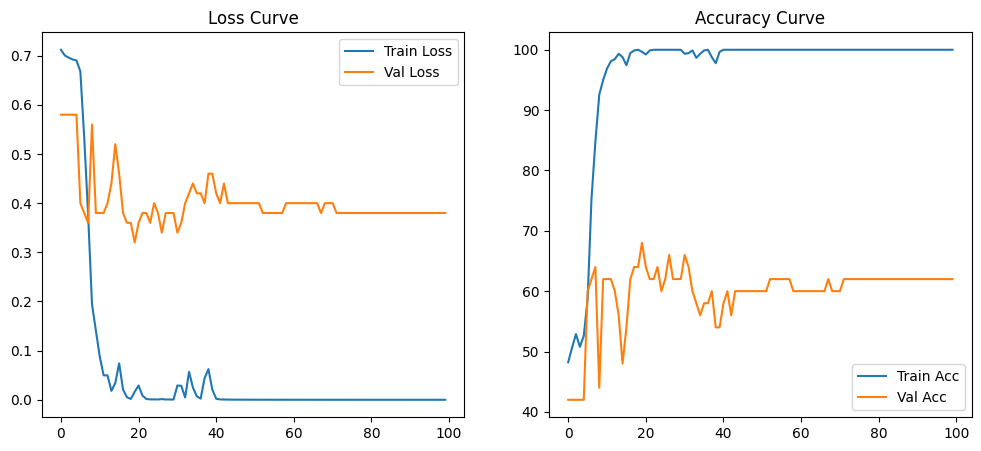

In [13]:
# ======================
# Plot Curves
# ======================
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.legend(); plt.title("Loss Curve")

plt.subplot(1,2,2)
plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.legend(); plt.title("Accuracy Curve")
plt.show()


✅ Test Accuracy: 44.00%


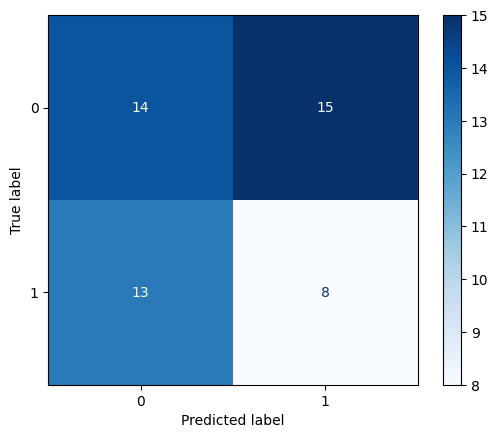

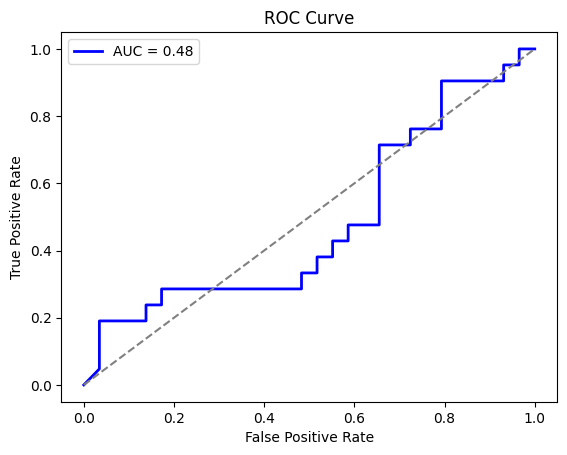

In [14]:
# ======================
# Test Evaluation
# ======================
test_acc, test_preds, test_labels_actual, test_probs = evaluate(model, test_loader)
print(f"\n✅ Test Accuracy: {test_acc:.2f}%")

cm = confusion_matrix(test_labels_actual, test_preds)
ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap=plt.cm.Blues)
plt.show()

fpr, tpr, _ = roc_curve(test_labels_actual, test_probs)
roc_auc = auc(fpr, tpr)
plt.figure(); plt.plot(fpr, tpr, color='blue', lw=2, label=f"AUC = {roc_auc:.2f}")
plt.plot([0,1], [0,1], color='gray', linestyle='--')
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curve"); plt.legend(); plt.show()


In [15]:

  # Rank Top 10 Resumes
all_resumes = []
model.eval()
with torch.inference_mode():
    for i in range(len(test_texts)):
        encoding = tokenizer(test_texts[i], truncation=True, padding="max_length", max_length=128, return_tensors="pt")
        input_ids = encoding["input_ids"].to(device)
        attention_mask = encoding["attention_mask"].to(device)
        outputs = model(input_ids, attention_mask)
        probs = torch.softmax(outputs, dim=1)
        score, pred_class = torch.max(probs, dim=1)
        all_resumes.append({
            "Role": test_job_roles[i],
            "Resume": test_texts[i],
            "Job_Description": test_job_desc[i],
            "Predicted_Label": label_encoder.inverse_transform([pred_class.item()])[0],
            "Score": score.item()
        })

ranked_resumes = sorted(all_resumes, key=lambda x: x["Score"], reverse=True)

print("\n===== Top 10 Ranked Resumes =====\n")
for idx, r in enumerate(ranked_resumes[:10], 1):
    print(f"Rank {idx}: Role = {r['Role']}, Predicted = {r['Predicted_Label']}, Score = {r['Score']:.4f}")
    print(f"Job Description: {r['Job_Description']}")
    print(f"Resume: {r['Resume'][:200]}...\n")
    print("-"*80)




===== Top 10 Ranked Resumes =====

Rank 1: Role = Database Administrator, Predicted = reject, Score = 1.0000
Job Description: Take the lead in driving innovation as a Database Administrator in a collaborative environment focused on excellence in software engineering.
Resume: Here's a sample resume for Jeremy Johnson:

Jeremy Johnson
Contact Information:

* Address: 123 Main St, Anytown, USA 12345
* Phone: (555) 555-5555
* Email: [jeremyjohnson@email.com](mailto:jeremyjohn...

--------------------------------------------------------------------------------
Rank 2: Role = Cloud Engineer, Predicted = reject, Score = 1.0000
Job Description: If you're passionate about cloud technologies, we need your expertise to help us deliver impactful products as a Cloud Engineer.
Resume: Here's a professional resume for Denise Thomas:

Denise Thomas
Cloud Engineer

Contact Information:

* Phone: (555) 123-4567
* Email: [dthomas@email.com](mailto:dthomas@email.com)
* LinkedIn: linkedin...

------------

In [16]:
# ======================
# Single Resume Check
# ======================
single_path = "/kaggle/input/single-data-set-for-cv-resume-3/Emma Johnson.txt"  # Upload single resume file
with open(single_path, "r", encoding="utf-8") as f:
    resume_text = f.read()  # ✅ make sure variable name matches

# Tokenize
encoding = tokenizer(resume_text, truncation=True, padding="max_length", max_length=128, return_tensors="pt")
input_ids = encoding["input_ids"].to(device)
attention_mask = encoding["attention_mask"].to(device)

# Model prediction
model.eval()
with torch.inference_mode():
    outputs = model(input_ids, attention_mask)
    probs = torch.softmax(outputs, dim=1)
    score, pred_class = torch.max(probs, dim=1)
    predicted_label = label_encoder.inverse_transform([pred_class.item()])[0]

print(f"Prediction: {predicted_label}, Confidence: {score.item():.4f}")

# Suggestions
if predicted_label != 'Hire':
    print("\n💡 To improve this CV:")
    print("- Highlight key skills relevant to the Role.")
    print("- Include quantified achievements or project outcomes.")
    print("- Ensure keywords match the Job Description.")
else:
    print("\n✅ This CV is already strong for the given role!")


Prediction: reject, Confidence: 0.5694

💡 To improve this CV:
- Highlight key skills relevant to the Role.
- Include quantified achievements or project outcomes.
- Ensure keywords match the Job Description.
